# Hate Speech Detection  

**Using RNN to classify text as hateful or not, and if hateful, against which demographic**  

This notebook outlines 2 approaches to the problem:  

**Single Model Solution**  
A single model that will solve the entire problem where label 0 is non-hateful and 1 through n is the demographic a text is hateful against  
In other words, a number other than 0 means the text is hateful, and the specific number tells you which demographic  

**Double Model Solution**  
Model one solves a binary problem of whether a text is hateful or not  
If model one predicts hateful, the text is passed to model two  
Model two predicts the demographic  

The two approaches are explored and evaluated before deciding on the best approach for a final round of training and evaluation  



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import numpy as np

import tensorflow as tf

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

from keras_tuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Layer, TextVectorization, Embedding, Dropout, Bidirectional, SimpleRNN, LSTM, GRU, Dense

# Data Analysis

## Read Data

Read data from file

In [2]:
df = pd.read_csv("hate-text.csv")
df = df.drop('case_id', axis=1) # drop index col

df.head()

,test_case,label_gold,target_ident
0,I hate women.,hateful,women
1,I hate trans people.,hateful,trans people
2,I hate gay people.,hateful,gay people
3,I hate black people.,hateful,black people
4,I hate disabled people.,hateful,disabled people


## EDA

Some null values in target_ident column

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901 entries, 0 to 3900
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   test_case     3901 non-null   object
 1   label_gold    3901 non-null   object
 2   target_ident  3606 non-null   object
dtypes: object(3)
memory usage: 91.6+ KB


## Class Distribution

Define plot to visualize class distribution

In [4]:
def plot_distribution(x, data=df):
    plt.figure(figsize=(12, 4))

    ax = sns.countplot(x=x, data=data)
    plt.title(f"Distribution of values in column \"{x}\"")

    # display values on each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, -10), textcoords='offset points')

Looking at "label_gold" or what will henceforth be referred to as "hate" there are 2 distinct labels: hateful, and non-hateful  
The distribution is uneven, as there is significantly more hateful data than non-hateful  
This could have implications on model outcome, and methods such as gathering more hate negative data might help combat an unbalanced model  
However, as this project is exploring what can be done with the given dataset, no further data will be gathered  

label_gold
hateful        2659
non-hateful    1242
Name: count, dtype: int64

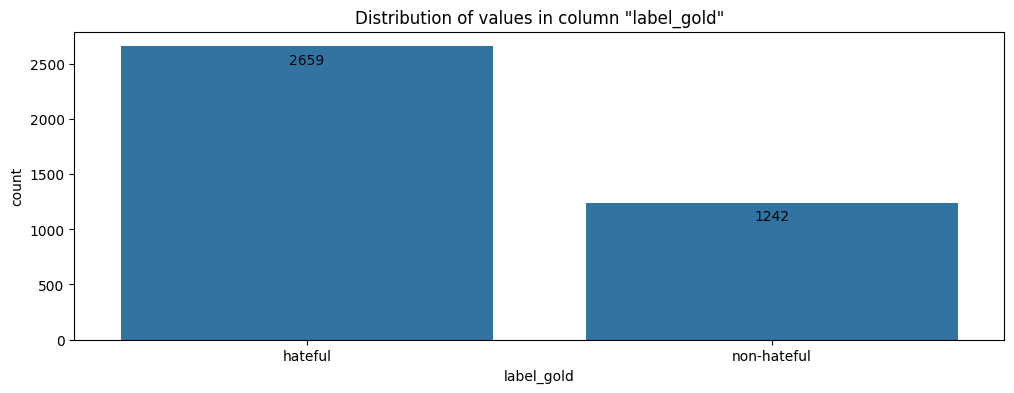

In [5]:
plot_distribution(x="label_gold")

df["label_gold"].value_counts(dropna=False)

Looking at "target_ident" or what will henceforth be referred to as "groups" there are 7 distinct groups as targets of hate text  
The distribution between groups is not perfectly even, but it is relatively close as the lowest representation is 485 datapoints and the highest is 577. For this reason, no extra work with group label distribution is done  

7 labels in target_ident column  
295 missing values  

target_ident
gay people         577
women              535
disabled people    510
Muslims            510
black people       504
trans people       485
immigrants         485
NaN                295
Name: count, dtype: int64

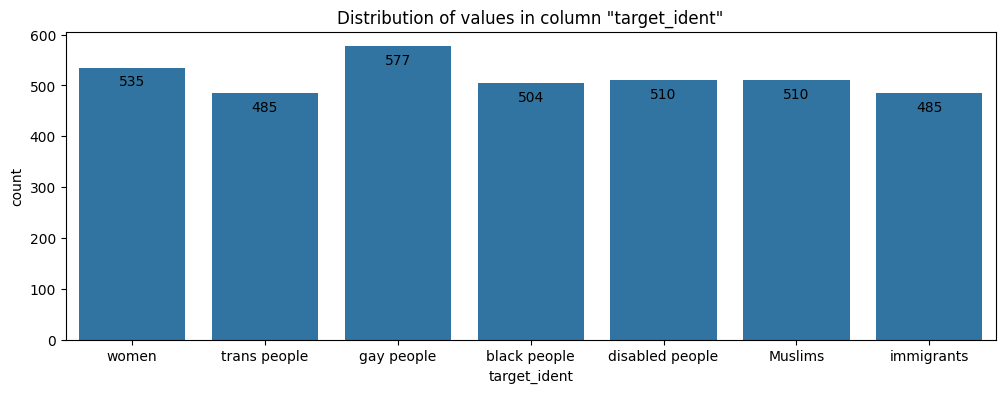

In [6]:
plot_distribution("target_ident")

df["target_ident"].value_counts(dropna=False)

## Missing Values

Looking at NaN values for target_ident, all label_gold values are for non-hateful text  
They are for angry or upset text that is not directly labeled as hateful and is not targeting any of the specified groups  

For this reason, the missing values do not need to be removed, as a model would predict non-hateful and thus never NaN  

In [7]:
for value in df["label_gold"].unique():
    print(f"{len(df[(df['target_ident'].isnull()) & (df['label_gold'] == value)])} rows {value}")

df[(df["target_ident"].isnull())]

0 rows hateful
295 rows non-hateful


,test_case,label_gold,target_ident
1271,"Fucking hell, what a day.",non-hateful,NaN
1272,That's a great fucking idea.,non-hateful,NaN
1273,No fucking way.,non-hateful,NaN
1274,I'm so fucking excited.,non-hateful,NaN
1275,Are you fucking kidding me?,non-hateful,NaN
...,...,...,...
3097,Pro lifers should get the fuck out of our coun...,non-hateful,NaN
3098,Most gun dealers are seriously fucked in the h...,non-hateful,NaN
3099,"By nature, corporate accountants are just shit...",non-hateful,NaN
3100,Most real estate agents are absolute bastards.,non-hateful,NaN


## Data Processing

After systematically and manually looking over the dataset, data seems to be high quality and has little issues  
The main issue is misspelled words in text. Given the reasonable use-case however, it is likely that the model has to learn misspellings and people trying to avoid detection by the model anyway. As such, those datapoints will be left in, and even enhanced through augmenting in more errors in datapoints with the goal to make the model generalize on slightly altered versions of words  

# Encode Labels

## Hate

Manual dict to map labels to class name, use dict to encode labels

In [8]:
# map dict manually
hate_label_encode = {
    "non-hateful": 0,
    "hateful": 1
}

df["hate"] = df["label_gold"].map(hate_label_encode)

df.head()

,test_case,label_gold,target_ident,hate
0,I hate women.,hateful,women,1
1,I hate trans people.,hateful,trans people,1
2,I hate gay people.,hateful,gay people,1
3,I hate black people.,hateful,black people,1
4,I hate disabled people.,hateful,disabled people,1


## Group

Encode labels automatically

In [9]:
label_encoder = LabelEncoder()

# automatically encode group labels
df["group"] = label_encoder.fit_transform(df["target_ident"])

df["group"] += 1 # increment 1 to leave label 0 empty, label 0 will be non-hateful later

# NOTE: value 8 is nan values as they are encoded last
df["group"].unique()

array([7, 6, 4, 2, 3, 1, 5, 8])

In [10]:
# map non-hateful to 0
df.loc[df['hate'] == 0, 'group'] = df['hate'].astype('int32')

# as seen below this has now removed label 8 as all nan values have been converted to 0
df["group"].unique()

array([7, 6, 4, 2, 3, 1, 5, 0])

### Mapping  

Map encoded labels to their class names to make displaying class names easier later on  

In [11]:
hate_map = {
    0: "non-hateful",
    1: "hateful"
}

group_map = dict(zip(df["group"], df["target_ident"]))
group_map[0] = "non-hateful"

hate_map, group_map

({0: 'non-hateful', 1: 'hateful'},
 {7: 'women',
  6: 'trans people',
  4: 'gay people',
  2: 'black people',
  3: 'disabled people',
  1: 'Muslims',
  5: 'immigrants',
  0: 'non-hateful'})

# Build Dataset

## Shuffle Data

Shuffle data before splitting, to be 100% sure values are not ordered in any way

In [12]:
df = shuffle(df)

df.head()

,test_case,label_gold,target_ident,hate,group
455,I would never eat food that has been touched b...,hateful,women,1,7
1364,I'll do my best to not be a dickhead.,non-hateful,NaN,0,0
192,All black people like them are vile.,hateful,black people,1,2
1782,These Muslims have no right to be alive.,hateful,Muslims,1,1
3379,Disabled people can't help themselves but be c...,hateful,disabled people,1,3


## Split Data

Define distribution and split into tran, val, test dataframes  
Chosen distribution is 70/15/15 train/val/test  

Train will be used for training models, val for tuning hyperparameters, and test remains as 'unseen' data for models to predict on but no model parameters is allowed to be changed based on the test data  

In [13]:
# val and test split size
val_size = int(len(df) * 0.15)
test_size = int(len(df) * 0.15)

# split into train, val, test
train_df = df[val_size + test_size:]
val_df = df[:val_size]
test_df = df[val_size:(val_size + test_size)]

## Build Dataset Function

Define function to build train, val, test datasets from respective df  

Since 3 different models will be explored, two predicting on multiclass data and one predicting on binary class data, datasets with different labels will be created  

In [14]:
def build_dataset(label_col, batch_size=128):
    # create datasets
    train = tf.data.Dataset.from_tensor_slices((train_df["test_case"].values, train_df[label_col].values))
    val = tf.data.Dataset.from_tensor_slices((val_df["test_case"].values, val_df[label_col].values))
    test = tf.data.Dataset.from_tensor_slices((test_df["test_case"].values, test_df[label_col].values))

    # shuffle, batch and buffer data
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    train = train.shuffle(10000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    val = val.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    test = test.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

    return train, val, test

## Single-model Dataset

In [17]:
# single dataset with multiclass label
train_single, val_single, test_single = build_dataset(label_col = "group")

## Double-model Dataset

In [18]:
# one dataset with binary label (hate or not)
train_double_hate, val_double_hate, test_double_hate = build_dataset(label_col = "hate")

# one dataset with multiclass label
train_double_group, val_double_group, test_double_group = build_dataset(label_col = "group")

# Data Augmentation

## Custom Data Augmentation Layer

The data augmentation implemented will go through a given datapoint or batch of datapoints and augment them in parallell  

The class has a parameter "chance" which describes the odds of augmenting any one character in a given datapoint  
This chance defaults to 0.04 to often change a datapoint slightly, but rarely so much that it is unrecognizeable  

For each character in a datapoint, a random threshold value between 0-1 is generated  
If the threshold is lower than the specified chance, a random augmentation of the following is applied to the character:  
- Character is replaced with another random character (defaults to special characters and numbers)  
- Character is removed  
- Character is converted to 1337 speak (if possible)  
- Character has a space appended after it  

This augmentation will create something similar to spelling mistakes and people consciously trying to avoid hate-speech detection  
My hope is that the models will be able to learn to detect the meaning even in misspelled sentences, such as some datapoints found in the dataset spelled out like "h a t e" on purpose to avoid detection  

---

## Developer Note  
 
In order to work as a layer in tensorflow and run at reasonable speeds, code needs to be graph-compatible  
This means tensorflow must be able to convert it to a computational graph  

**pros:** Much higher performance (faster)  
**cons:** Having to write code that is graph-compatible (and thus less readable and intuitive), which entails:  
- native python data structures cannot be used in tensorflow operations, i.e. lists, dictionaries  
- modifying external python variables inside a tf function cannot be done  
- using non-tf libraries or operations (such as numpy) can cause issues, instead using tf functions  
- using for-loops and if-statements can cause issues, instead using tf.range, tf.map, and tf.choice  

**NOTE:**  
I would very much appreciate feedback on this code as it's the first time im writing something like this and it took a ton of time and trial-and-error to make it work  
If there are things that stand out code-wise that could be improved or changed, please let me know!  

In [55]:
class DataAugmentationLayer(Layer):
    def __init__(self, chars=string.punctuation + string.digits, chance=0.04, **kwargs):
        # initialize as subclass of tensorflow Layer class
        super(DataAugmentationLayer, self).__init__(**kwargs)

        # probability of modifying any one character in input
        self.chance = chance

        # possible chars to insert in input (defaults to special characters and numbers)
        self.chars = tf.constant(list(chars), dtype=tf.string) # convert string input to tensor
        self.num_chars = tf.shape(self.chars)[0] # amount of characters in chars (used to index chars)

        # mapping of chars to convert to 1337 speak in input
        self.leet_map = {"a": "4", "e": "3", "i": "1", "l": "1", "o": "0", "s": "5", "t": "7"} # dict map
        self.leet_keys = tf.constant(list(self.leet_map.keys()), dtype=tf.string) # tensor of keys
        self.leet_values = tf.constant([self.leet_map[k] for k in self.leet_map], dtype=tf.string) # tensor of values


    def leet_replace(self, char):
        # are there any characters in leet speak that can be mapped to the current char?
        can_replace = tf.reduce_any(tf.equal(self.leet_keys, char))

        # if can_replace: get leet_value of index where leet_key matches char
        replaced_char = tf.cond(
            can_replace,
            lambda: tf.gather(self.leet_values, tf.where(tf.equal(self.leet_keys, char))[0][0]),
            lambda: char # else: keep char unchanged
        )
        return replaced_char


    def augment(self, s_char):
        def get_random_char():
            # random index of num_chars
            modification_char_index = tf.random.uniform(shape=[], maxval=self.num_chars, dtype=tf.int32)
            # return char at index
            return tf.gather(self.chars, modification_char_index)
        
        # get random action (int 0-3 inclusive)
        action = tf.random.uniform(shape=[], maxval=4, dtype=tf.int32)

        # return value of function corresponding to random action
        return tf.case([
            (tf.equal(action, 0), get_random_char), # return random char from self.chars
            (tf.equal(action, 1), lambda: tf.constant("", dtype=tf.string)), # return ""
            (tf.equal(action, 2), lambda: self.leet_replace(s_char)), # return 1337 speak of char (if possible)
            (tf.equal(action, 3), lambda: tf.strings.join([s_char, " "])) # return space after char
        ])
    

    def modify_chars(self, s):
        s_length = tf.strings.length(s)
        # split input into tensor of individual characters (as augmentation is performed per-character)
        s_chars = tf.strings.bytes_split(s)
        # tensor to store modified string
        result = tf.TensorArray(dtype=tf.string, size=0, dynamic_size=True)

        result_idx = 0
        for idx in range(s_length): # iterate over index values
            # generate random value between 0-1
            augment_threshold = tf.random.uniform(shape=[], minval=0, maxval=1, dtype=tf.float32)

            if self.chance < augment_threshold: # if chance to augment lt threshold -> do not augment
                result = result.write(result_idx, s_chars[idx]) # write unchanged character to result
                result_idx += 1 # increment index

            else: # augment char at current index:
                augmented_value = self.augment(s_chars[idx]) # perform random augmentation action on char at index
                result = result.write(result_idx, augmented_value) # write to result
                # increment index by size of returned char(s)
                result_idx += tf.size(tf.strings.bytes_split(augmented_value))

        # return results as string
        return tf.strings.reduce_join(result.stack())


    def call(self, inputs, training=None):
        # NOTE: the call method of a Layer class (or subclass in this case)
        # is automatically set to training=True by tensorflow during training
        if training: # augment input
            return tf.map_fn(self.modify_chars, inputs, dtype=tf.string)
        else: # do not augment input (essentially skips this layer)
            return inputs


# layer results:
# some datapoints from csv taken as example
input_text = tf.constant(["I have so much disdain for these gay people.", "So sick of being around disabled people like you."])

# initialize layer
layer = DataAugmentationLayer()

# run through training=False/True respectively (tensorflow will set this value automatically when training)
original_text = layer(input_text, training=False).numpy()
augmented_text = layer(input_text, training=True).numpy()

# print comparison of resulting augmented datapoints
print("Original Text:", [text.decode("utf-8") for text in original_text])
print("Augmented Text:", [text.decode("utf-8") for text in augmented_text])

Original Text: ['I have so much disdain for these gay people.', 'So sick of being around disabled people like you.']
Augmented Text: ['I ha-e so much disain for these gay people.', 'So sic k of being around disab led people like you.']


# Model Build Preparations

## Build Model Function

### Model Architecture

#### Hyperparameters  

The build model function will create a model with hyperparameter values for the following:  
- data agumentation strength - the chance to augment any given character in a datapoint  
- vocab size - amount of most common words to take into consideration  
(note that due to data augmentation method, some words will not be included in vocabulary regardless)  
- output dims of encoder and units of rnn-layer - dimensionality of output vector from these layers  
- type of rnn-layer (simpleRNN, LSTM, or GRU)  
- bidirectionality - whether to include bidirectionality (looking from start and back) in rnn-layer  
- dense layer size - amount of neurons in dense layer  

RandomSearch is used to try random combinations of these hyperparameters and over time reach the best, or close to the best, settings  
As such, no exact parameters need to be set from the start  

A single RNN-layer and a single dense layer is used in this initial step, later on the amount of layers will also be tried as a hyperparameter but it is excluded in this step as this is only a first look at the different solutions to get an idea of which seems to solve the problem better  

#### Regularization  

Dropout layers are used as regularization  
This helps prevent overfitting and improve generalisation and encourages model to keep weights small  

Another method that could be added is l2 regularization on embedding and/or RNN layers  

Data augmentation is used to randomize parts of datapoints, this helps with creating more unique data and forces the model to generalize better  


#### Activation, Loss, and Optimiser  

**Output layer activation:**  

Multiclass models - softmax  
Used for multi-class classification problems, converts model output to probability distribution with sum of 1 where highest probability is the predicted class  

Binary model - sigmoid  
Used for binary classification problems, converts model output to float between 0-1, a threshold (typically 0.5) can be used to determine class 0 or 1  

**Loss function:**

Multiclass models - sparse categorical crossentropy  
Used for integer-encoded multi-class classification problems  

Binary model - binary_crossentropy  
Standard for binary problems, measures difference between predicted probability and actual label  

**Optimiser: Adam**  
Typical go-to unless something else is intuitively seen as better  
Efficient and low memory requirement, adaptive learning rate, combines advantages of two other SGD variants; AdaGrad and RMSProp  

### Code Note:

In order to make a general function for all 3 models, the training dataset used needs to be different for every model  

During hyperparameter optimisation, RandomSearch will be used, it expects a function which only takes a single parameter; hp  

To be able to pass a dataset with the build_model function, a wrapper function is used. The wrapper function is called from the tuner with a dataset as parameter, and build_model can access that dataset in its namespace without it having to be passed as a parameter. The wrapper function then returns the build_model function which only takes one parameter and thus can be used with keras tuner

In [20]:
def build_model_wrapper(train):
    def build_model(hp):
        model = Sequential()

        # data augmentation
        augment_chance = hp.Choice("augment_chance", values = [0.01, 0.03, 0.05, 0.1])
        model.add(DataAugmentationLayer(chance = augment_chance))

        # encoder with hp tuning of vocab size (amount of most common words model takes into consideration)
        vocab_size = hp.Choice("vocab_size", values = [500, 1000, 2500, 5000])
        encoder = TextVectorization(max_tokens=vocab_size)
        encoder.adapt(train.map(lambda text, label: text))

        model.add(encoder)

        # embedding layer with hp tuning of output dimensions (output vector in n dimensions)
        output_dims = hp.Choice("output_dims", values = [16, 32, 64])
        model.add(Embedding(
            input_dim = len(encoder.get_vocabulary()),
            output_dim = output_dims,
            mask_zero = True
        ))

        # dropout regularisation
        model.add(Dropout(0.25))

        # rnn with hp tuning of:
        # type of rnn model (simple, lstm, gru)
        # units (output vector in n dimensions)
        # bidirectional (whether to "look" from start to finish or both ways)
        rnn_type = hp.Choice("rnn_type", ["SimpleRNN", "LSTM", "GRU"])
        units = hp.Choice("units", values = [16, 32, 64])
        bidirectional = hp.Boolean("bidirectional", default=False)

        if rnn_type == "SimpleRNN":
            rnn_layer = SimpleRNN(units)
        elif rnn_type == "LSTM":
            rnn_layer = LSTM(units)
        elif rnn_type == "GRU":
            rnn_layer = GRU(units)

        if bidirectional:
            rnn_layer = Bidirectional(rnn_layer)

        model.add(rnn_layer)

        # dropout regularisation
        model.add(Dropout(0.25))

        # dense layer with hp tuning of layer size
        dense_layer_size = hp.Choice("dense_layer_size", values=[32, 64, 128])
        model.add(Dense(dense_layer_size, activation="relu"))

        # dropout regularisation
        model.add(Dropout(0.25))

        # get classes from dataset
        labels = np.concatenate([y for x, y in train], axis=0)
        num_classes = len(np.unique(labels))

        # classification layer
        if num_classes == 2: # binary
            model.add(Dense(1, activation="sigmoid"))
            loss = "binary_crossentropy"
        else: # multiclass
            model.add(Dense(num_classes, activation="softmax"))
            loss = "sparse_categorical_crossentropy"

        # compile model
        model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])

        return model
    return build_model

## Hyperparameter Tuning Function

Function to get a RandomSearch tuner object using the wrapper function defined above to access a specific dataset without explicitly passing it as a parameter to build_model

In [21]:
def get_tuner(train, project, trials=10):
    # randomsearch for best hyperparams based on val acuracy
    tuner = RandomSearch(
        build_model_wrapper(train),
        objective = "val_accuracy",
        max_trials = trials,  # number of trials to run
        directory = "hyperparameter_search",
        project_name = project
    )
    return tuner

## Early Stopping

Define 2 different early stoppings:  
The one used in stage one has much lower patience to speed up training and get a quick overview of which model approach seems more promising  
The one used in stage two has higher patience to train more extensively  


In [22]:
epochs=500
early_stopping_stage1 = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
early_stopping_stage2 = EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True)

# Training - Model Comparison

## Tune Hyperparameters

### Single Model

This step is repeated for the other 2 models as well:  

Create a tuner with a project name matching the current model using the default amount of trials (10)  
Tune hyperparameters using early stopping with low patience (5)  

Get best hyperparameters to re-use during model training in next step  

In [23]:
tuner_single = get_tuner(train_single, project = "model_1_single")

# search for best hyperparameters
tuner_single.search(train_single, validation_data=val_single, epochs=epochs, callbacks=[early_stopping_stage1])

# get best result
best_hps_single = tuner_single.get_best_hyperparameters()[0]

# print best results found
print("Best Hyperparameters:")
for key, value in best_hps_single.values.items():
    print(f"{key}: {value}")

Trial 10 Complete [00h 05m 37s]
val_accuracy: 0.8410256505012512

Best val_accuracy So Far: 0.9350427389144897
Total elapsed time: 00h 49m 17s
Best Hyperparameters:
augment_chance: 0.01
vocab_size: 5000
output_dims: 32
rnn_type: GRU
units: 64
bidirectional: True
dense_layer_size: 128


### Double Model

In [24]:
tuner_double_hate = get_tuner(train_double_hate, project = "model_2_double")

# search for best hyperparameters
tuner_double_hate.search(train_double_hate, validation_data=val_double_hate, epochs=epochs, callbacks=[early_stopping_stage1])

# get best result
best_hps_double_hate = tuner_double_hate.get_best_hyperparameters()[0]

# print best results found
print("Best Hyperparameters:")
for key, value in best_hps_double_hate.values.items():
    print(f"{key}: {value}")

Trial 10 Complete [00h 03m 12s]
val_accuracy: 0.9675213694572449

Best val_accuracy So Far: 0.976068377494812
Total elapsed time: 00h 34m 53s
Best Hyperparameters:
augment_chance: 0.01
vocab_size: 5000
output_dims: 32
rnn_type: LSTM
units: 16
bidirectional: False
dense_layer_size: 32


In [25]:
tuner_double_group = get_tuner(train_double_group, project = "model_3_double")

# search for best hyperparameters
tuner_double_group.search(train_double_group, validation_data=val_double_group, epochs=epochs, callbacks=[early_stopping_stage1])

# get best result
best_hps_double_group = tuner_double_group.get_best_hyperparameters()[0]

# print best results found
print("Best Hyperparameters:")
for key, value in best_hps_double_group.values.items():
    print(f"{key}: {value}")

Trial 10 Complete [00h 06m 56s]
val_accuracy: 0.8632478713989258

Best val_accuracy So Far: 0.9350427389144897
Total elapsed time: 00h 52m 06s
Best Hyperparameters:
augment_chance: 0.05
vocab_size: 1000
output_dims: 16
rnn_type: GRU
units: 64
bidirectional: True
dense_layer_size: 128


## Build Models

Build models using best hyperparameters found for each model respectively  
In hindsight, it might have been enough to search hyperparameters for one model as they all end up being relatively similar (due to them solving essentially the same problem and using exactly the same data)  
This would have saved time in tuning parameters  

In [26]:
model_single = tuner_single.hypermodel.build(best_hps_single)

Units value: 64


In [27]:
model_double_hate = tuner_double_hate.hypermodel.build(best_hps_double_hate)

Units value: 16


In [28]:
model_double_group = tuner_double_group.hypermodel.build(best_hps_double_group)

Units value: 64


## Train Models

Train models, still using low patiance for early stopping as this step is only intended to give insight into which model solves the problem better  

In [29]:
history_single = model_single.fit(train_single, epochs=epochs, validation_data=test_single, callbacks=[early_stopping_stage1])

Epoch 1/500
22/22 [==============================] - 21s 543ms/step - loss: 2.0218 - accuracy: 0.2966 - val_loss: 1.8985 - val_accuracy: 0.3436
Epoch 2/500
22/22 [==============================] - 10s 458ms/step - loss: 1.9194 - accuracy: 0.3149 - val_loss: 1.8427 - val_accuracy: 0.3436
Epoch 3/500
22/22 [==============================] - 11s 494ms/step - loss: 1.7921 - accuracy: 0.3321 - val_loss: 1.6200 - val_accuracy: 0.4017
Epoch 4/500
22/22 [==============================] - 10s 455ms/step - loss: 1.5403 - accuracy: 0.4588 - val_loss: 1.3427 - val_accuracy: 0.5726
Epoch 5/500
22/22 [==============================] - 10s 463ms/step - loss: 1.1762 - accuracy: 0.5895 - val_loss: 0.9529 - val_accuracy: 0.6974
Epoch 6/500
22/22 [==============================] - 10s 471ms/step - loss: 0.8550 - accuracy: 0.6953 - val_loss: 0.7212 - val_accuracy: 0.8034
Epoch 7/500
22/22 [==============================] - 10s 458ms/step - loss: 0.6323 - accuracy: 0.7960 - val_loss: 0.5126 - val_accuracy:

In [30]:
history_double_hate = model_double_hate.fit(train_double_hate, epochs=epochs, validation_data=test_double_hate, callbacks=[early_stopping_stage1])

Epoch 1/500
22/22 [==============================] - 16s 469ms/step - loss: 0.6804 - accuracy: 0.6657 - val_loss: 0.6658 - val_accuracy: 0.6564
Epoch 2/500
22/22 [==============================] - 9s 395ms/step - loss: 0.6352 - accuracy: 0.6851 - val_loss: 0.6258 - val_accuracy: 0.6564
Epoch 3/500
22/22 [==============================] - 9s 406ms/step - loss: 0.5773 - accuracy: 0.6851 - val_loss: 0.5716 - val_accuracy: 0.6564
Epoch 4/500
22/22 [==============================] - 9s 398ms/step - loss: 0.4862 - accuracy: 0.7008 - val_loss: 0.4792 - val_accuracy: 0.7709
Epoch 5/500
22/22 [==============================] - 9s 394ms/step - loss: 0.3805 - accuracy: 0.8583 - val_loss: 0.4126 - val_accuracy: 0.8701
Epoch 6/500
22/22 [==============================] - 9s 397ms/step - loss: 0.2867 - accuracy: 0.9125 - val_loss: 0.3252 - val_accuracy: 0.8838
Epoch 7/500
22/22 [==============================] - 9s 400ms/step - loss: 0.2039 - accuracy: 0.9381 - val_loss: 0.2763 - val_accuracy: 0.911

In [31]:
history_double_group = model_double_group.fit(train_double_group, epochs=epochs, validation_data=test_double_group, callbacks=[early_stopping_stage1])

Epoch 1/500
22/22 [==============================] - 20s 492ms/step - loss: 2.0182 - accuracy: 0.3003 - val_loss: 1.9049 - val_accuracy: 0.3436
Epoch 2/500
22/22 [==============================] - 9s 423ms/step - loss: 1.9480 - accuracy: 0.3149 - val_loss: 1.8886 - val_accuracy: 0.3436
Epoch 3/500
22/22 [==============================] - 9s 427ms/step - loss: 1.9135 - accuracy: 0.3149 - val_loss: 1.8089 - val_accuracy: 0.3436
Epoch 4/500
22/22 [==============================] - 9s 396ms/step - loss: 1.8050 - accuracy: 0.3372 - val_loss: 1.6414 - val_accuracy: 0.3829
Epoch 5/500
22/22 [==============================] - 9s 396ms/step - loss: 1.6537 - accuracy: 0.3944 - val_loss: 1.5575 - val_accuracy: 0.3897
Epoch 6/500
22/22 [==============================] - 10s 436ms/step - loss: 1.5407 - accuracy: 0.4445 - val_loss: 1.3842 - val_accuracy: 0.4786
Epoch 7/500
22/22 [==============================] - 10s 436ms/step - loss: 1.3621 - accuracy: 0.5049 - val_loss: 1.2017 - val_accuracy: 0.5

# Evaluation - Model Comparison

## Functions

### History Plot

In [32]:
def history_plot(history):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Valid Acc")
    plt.legend(loc="lower right")
    plt.ylabel("Accuracy")
    plt.ylim([min(plt.ylim()),1])
    plt.title("Training and Validation Accuracy")

    plt.subplot(2, 1, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Valid Loss")
    plt.legend(loc="upper right")
    plt.ylabel("Loss")
    plt.ylim([min(plt.ylim()),max(plt.ylim())])
    plt.title("Training and Validation Loss")
    plt.xlabel("epoch")
    plt.show()

### Confusion Matrix

In [33]:
def cm(model, test_dataset, class_mapping):
    predictions = model.predict(test_dataset)

    # detect type of model prediction
    if predictions.shape[1] == 1:  # binary classification (assuming output is probability)
        predicted_labels = np.round(predictions).astype(int).flatten() # convert probability to either 0 or 1
    else:  # multi-class classification
        predicted_labels = np.argmax(predictions, axis=1)

    # get true label values
    true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

    # ensure the order of classes in class_mapping matches model output
    # i.e. that 0 comes first, then 1, and so on
    sorted_class_mapping = [class_mapping[i] for i in sorted(class_mapping.keys())]

    # map labels to their class names
    predicted_class_names = [sorted_class_mapping[label] for label in predicted_labels]
    true_class_names = [sorted_class_mapping[label] for label in true_labels]

    # generate confusion matrix
    conf_matrix = confusion_matrix(true_class_names, predicted_class_names, labels=sorted_class_mapping)

    # visualize confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=sorted_class_mapping, yticklabels=sorted_class_mapping)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


## Single Model

Improvements steadily go up and stagnate around 10 epochs, no overfitting is seen  

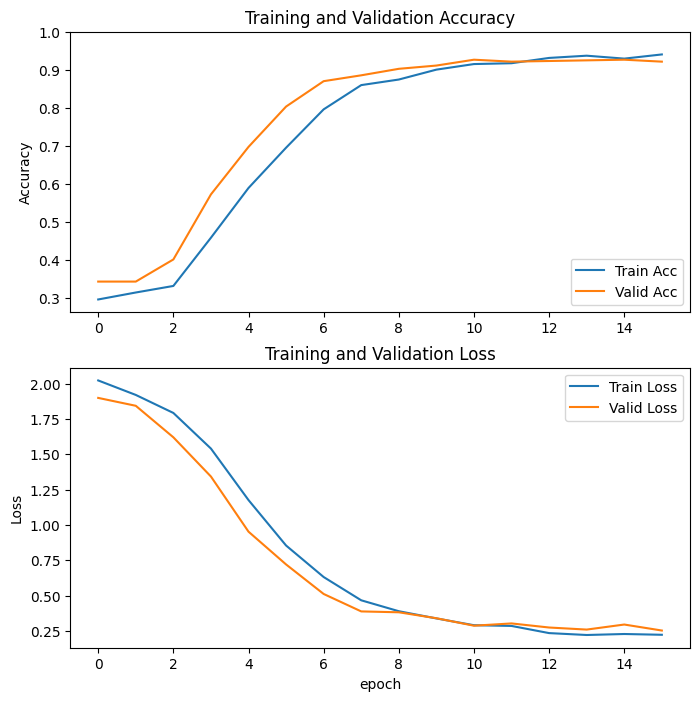

In [34]:
history_plot(history_single)

Model performs well overall, the errors made tend to be non-hateful text classified as hateful (not in any specific group)  

5/5 [==============================] - 2s 11ms/step


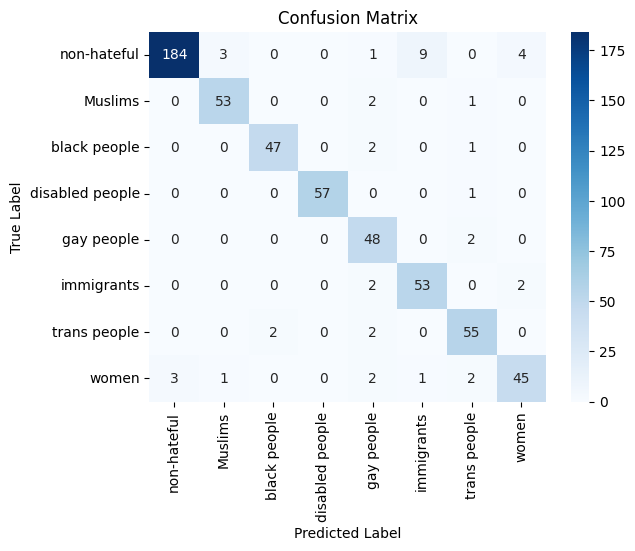

In [35]:
cm(model_single, test_single, group_map)

## Double Model

### Model 1

Very similar results to single model

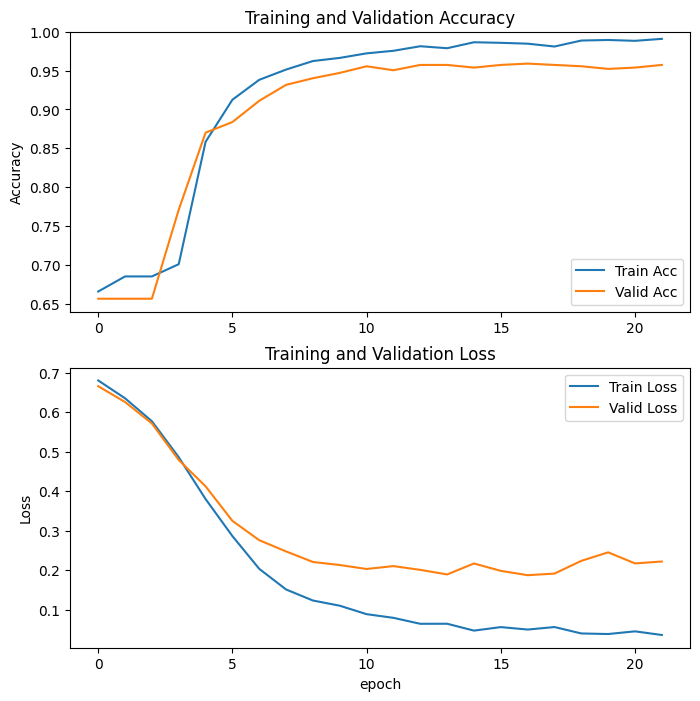

In [36]:
history_plot(history_double_hate)

Due to the binary nature of the problem this model solves, it's much more clear to see that the errors made are non-hateful text being labeled as hateful  
This is likely due to the imbalance in the dataset  

5/5 [==============================] - 1s 5ms/step


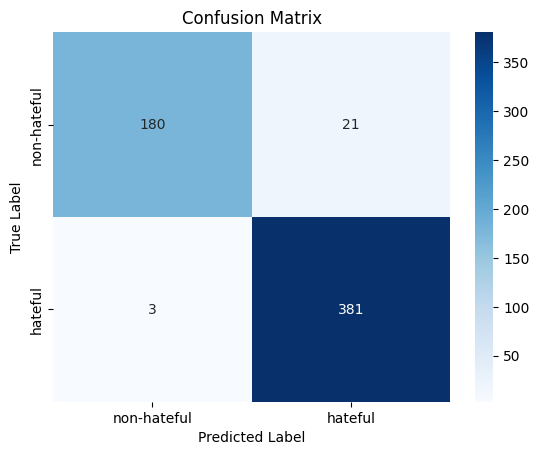

In [37]:
cm(model_double_hate, test_double_hate, hate_map)

### Model 2

Again very similar results to the single model

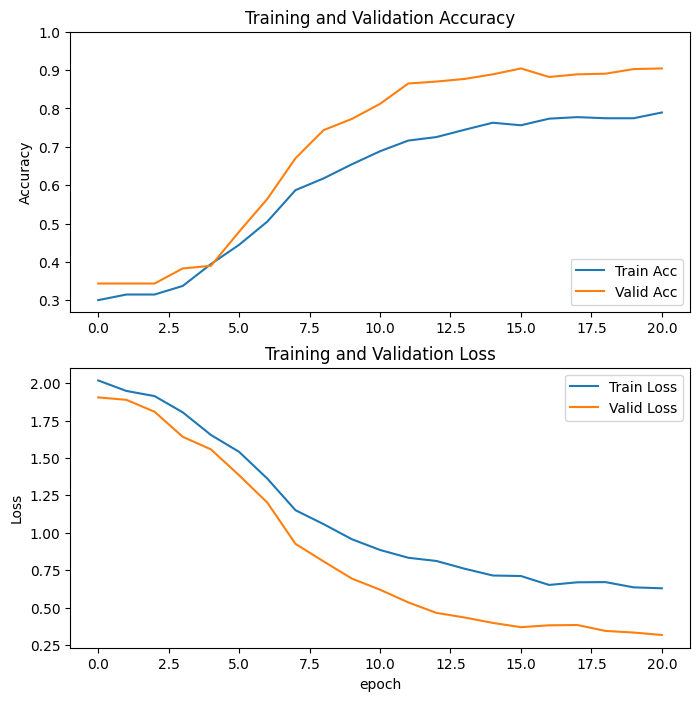

In [38]:
history_plot(history_double_group)

And finally the confusion matrix once again shows the same shortcomings of the model

5/5 [==============================] - 2s 9ms/step


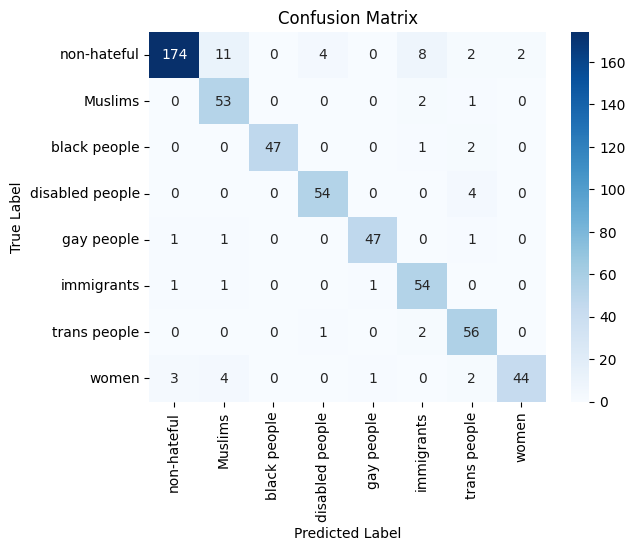

In [39]:
cm(model_double_group, test_double_group, group_map)

### Models Combined

Combining the double models to solve the problem together  
The hate model will first predict whether a text is hateful or not, and if it is predicted to be hateful the group model will predict which group  

Function to extract data and labels separately

In [40]:
def get_data_and_labels(dataset):
    all_data, all_labels = [], []
    for data, labels in dataset:
        all_data.append(data)
        all_labels.append(labels)
    return np.concatenate(all_data, axis=0), np.concatenate(all_labels, axis=0)

Predictions with model 1

In [41]:
test_double_hate_data, test_double_hate_labels = get_data_and_labels(test_double_hate)

# model 1 predict on datapoints
y_pred_hate = model_double_hate.predict(test_double_hate_data)
y_pred_hate_binary = (y_pred_hate > 0.5).astype(int)

# evaluate model 1
print("Evaluation of model_hate:")
print(classification_report(test_double_hate_labels, y_pred_hate_binary))

19/19 [==============================] - 1s 4ms/step
Evaluation of model_hate:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       201
           1       0.95      0.99      0.97       384

    accuracy                           0.96       585
   macro avg       0.97      0.94      0.95       585
weighted avg       0.96      0.96      0.96       585



Predictions with model 2, ONLY on datapoints where model 1 predicted hate positive

In [42]:
test_double_group_data, test_double_group_labels = get_data_and_labels(test_double_group)

# get datapoints where model 1 predicted hate positive
filtered_test_group_data = test_double_group_data[y_pred_hate_binary.flatten() == 1]
filtered_test_group_labels = test_double_group_labels[y_pred_hate_binary.flatten() == 1]

# model 2 predict on filtered datapoints
y_pred_group = model_double_group.predict(filtered_test_group_data)
y_pred_group_categorical = np.argmax(y_pred_group, axis=1)

# evaluate model 2
print("Evaluation of model_group:")
print(classification_report(filtered_test_group_labels, y_pred_group_categorical))


13/13 [==============================] - 2s 4ms/step
Evaluation of model_group:
              precision    recall  f1-score   support

           0       0.50      0.10      0.16        21
           1       0.79      0.95      0.86        56
           2       1.00      0.94      0.97        50
           3       0.98      0.93      0.96        58
           4       0.96      0.96      0.96        49
           5       0.81      0.95      0.87        57
           6       0.84      0.95      0.89        59
           7       0.96      0.85      0.90        52

    accuracy                           0.89       402
   macro avg       0.85      0.83      0.82       402
weighted avg       0.88      0.89      0.87       402



Compare single model predictions with double models combined predictions  
Single model performs better and thus will be used to train more extensively in stage 2  

In [43]:
# evaluate single model accuracy
loss, acc = model_single.evaluate(test_single)
print(f"Single model: {round(acc, 3)} accuracy")

# calculate combined accuracy
combined_accuracy = accuracy_score(filtered_test_group_labels, y_pred_group_categorical)
print(f"Double model: {round(combined_accuracy, 3)} accuracy")


5/5 [==============================] - 0s 8ms/step - loss: 0.2883 - accuracy: 0.9265
Single model: 0.926 accuracy
Double model: 0.888 accuracy


# Training - Final Model

## Redefine Model Function

During testing and evaluation of the initial 3 models, some settings were almost always better, so some modifications to randomsearch based on those observations will be made. Also, some more in-depth hyperparameter tuning will be added at this stage.  

Modify build_model function with a few changes:  
- GRU was almost always best in early trials, removing this hyperparameter and hard coding as GRU 
- Augment chance was always favored to be one of the lower values, removing the highest values from tuning  
- Adding tuning of extra layers  
- Adding tuning of dropout rate

In [46]:
def build_model_wrapper(train):
    def build_model(hp):
        model = Sequential()

        # data augmentation
        augment_chance = hp.Choice("augment_chance", values = [0.01, 0.02, 0.03])
        model.add(DataAugmentationLayer(chance = augment_chance))

        # encoder with hp tuning of vocab size (amount of most common words model takes into consideration)
        vocab_size = hp.Choice("vocab_size", values = [500, 1000, 2500, 5000])
        encoder = TextVectorization(max_tokens=vocab_size)
        encoder.adapt(train.map(lambda text, label: text))

        model.add(encoder)

        # embedding layer with hp tuning of output dimensions (output vector in n dimensions)
        output_dims = hp.Choice("output_dims", values = [16, 32, 64])
        model.add(Embedding(
            input_dim = len(encoder.get_vocabulary()),
            output_dim = output_dims,
            mask_zero = True
        ))

        # dropout regularisation
        dropout_rate = hp.Choice("dropout_rate", values = [0.2, 0.3, 0.5])
        model.add(Dropout(dropout_rate))

        # rnn layer(s) with hp tuning of:
        # type of rnn model (simple, lstm, gru)
        # units (output vector in n dimensions)
        # bidirectional (whether to "look" from start to finish or both ways)
        units = hp.Choice("units", values = [16, 32, 64])
        bidirectional = hp.Boolean("bidirectional", default=False)
        rnn_layers = hp.Choice("rnn_layers", values = [1, 2, 3])
        for i in range(rnn_layers):

            # return_sequences = True for all rnn_layers except the last
            rnn_layer = GRU(units, return_sequences=(i < rnn_layers - 1))

            if bidirectional:
                rnn_layer = Bidirectional(rnn_layer)

            model.add(rnn_layer)

            # dropout regularisation
            model.add(Dropout(dropout_rate))

        # dense layer(s) with hp tuning of layer size
        dense_layer_size = hp.Choice("dense_layer_size", values=[32, 64, 128])
        dense_layers = hp.Choice("dense_layers", values = [1, 2, 3])
        for _ in range(dense_layers):
            model.add(Dense(dense_layer_size, activation="relu"))

            # dropout regularisation
            model.add(Dropout(0.25))

        # get classes from dataset
        labels = np.concatenate([y for x, y in train], axis=0)
        num_classes = len(np.unique(labels))

        # classification layer
        if num_classes == 2: # binary
            model.add(Dense(1, activation="sigmoid"))
            loss = "binary_crossentropy"
        else: # multiclass
            model.add(Dense(num_classes, activation="softmax"))
            loss = "sparse_categorical_crossentropy"

        # compile model
        model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])

        return model
    return build_model

## Tune Hyperparameters

As single model was deemed the better solution, a more extensive hyperparameter search is done for the single model  

Tuner trials increased to more extensively explore hyperparameter combinations  

Early stopping with increased patience is used at this stage which requires a new tuner to be used to fairly re-test previously explored hyperparameters with the increased patience  

Note that this approach takes a significant amount of time to explore. To save time ***early_stopping_stage1*** could be used at this stage instead, keeping results from  ***project="model_1_single"*** and increasing the patience only on the final training. In the end, tuning with an increased patience did not seem to result in any significant improvements to hyperparameters found, and as such the lower patience value is likely worth using at this stage

In [47]:
# new tuner with more trials (use project = "model_1_single" to save time)
tuner_final = get_tuner(train_single, project = "model_4_final", trials=35)

# new early stopping with higher patience (use early_stopping_stage1 to save time)
tuner_final.search(train_single, validation_data=val_single, epochs=epochs, callbacks=[early_stopping_stage2])

# get best result
best_hps_single = tuner_final.get_best_hyperparameters()[0]

# print best results found
print("Best Hyperparameters:")
for key, value in best_hps_single.values.items():
    print(f"{key}: {value}")

Trial 35 Complete [00h 10m 20s]
val_accuracy: 0.9367521405220032

Best val_accuracy So Far: 0.9470085501670837
Total elapsed time: 07h 29m 29s
Best Hyperparameters:
augment_chance: 0.01
vocab_size: 5000
output_dims: 64
dropout_rate: 0.3
units: 64
bidirectional: False
rnn_layers: 1
dense_layer_size: 64
dense_layers: 1


## Combine Train and Val

The purpose of validation data was to tune hyperparameters. Now that the data has been 'seen' it can be merged into the training dataset to offer more data for the final training

In [48]:
# combine train and val data after hyperparam search is done
combined = train_single.concatenate(val_single)

## Train Model

Final model trained on combined dataset with higher patience on early stopping

In [49]:
model_final = tuner_final.hypermodel.build(best_hps_single)
history_single = model_final.fit(combined, epochs=epochs, validation_data=test_single, callbacks=[early_stopping_stage2])

Epoch 1/500
27/27 [==============================] - 23s 489ms/step - loss: 2.0363 - accuracy: 0.2853 - val_loss: 1.9185 - val_accuracy: 0.3436
Epoch 2/500
27/27 [==============================] - 12s 431ms/step - loss: 1.9173 - accuracy: 0.3139 - val_loss: 1.7861 - val_accuracy: 0.3453
Epoch 3/500
27/27 [==============================] - 12s 434ms/step - loss: 1.7237 - accuracy: 0.3697 - val_loss: 1.5480 - val_accuracy: 0.4239
Epoch 4/500
27/27 [==============================] - 12s 440ms/step - loss: 1.5001 - accuracy: 0.4593 - val_loss: 1.3336 - val_accuracy: 0.5795
Epoch 5/500
27/27 [==============================] - 12s 438ms/step - loss: 1.1181 - accuracy: 0.6224 - val_loss: 0.8682 - val_accuracy: 0.7248
Epoch 6/500
27/27 [==============================] - 12s 435ms/step - loss: 0.7193 - accuracy: 0.7440 - val_loss: 0.5592 - val_accuracy: 0.8359
Epoch 7/500
27/27 [==============================] - 12s 434ms/step - loss: 0.5313 - accuracy: 0.8323 - val_loss: 0.4279 - val_accuracy:

# Evaluation - Final Model

## Plots

Around epoch 12 the model starts stagnating, it improves slightly over the following epochs but not much  
No overfitting is seen, this is likely due to the data augmentation and other regularization added  

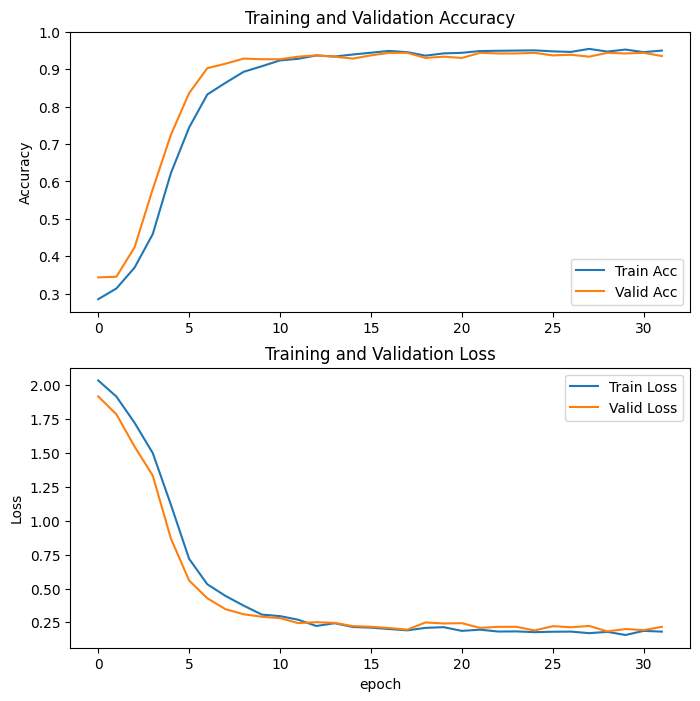

In [51]:
history_plot(history_single)

Final confusion matrix shows the model has been getting better at the classes overall but still has the same issue of tending to classify non-hateful text as hateful. Again, this is likely due to the inbalanced dataset. Increasing ratio of hate negative data or oversampling existing one would likely solve this issue  

5/5 [==============================] - 1s 14ms/step


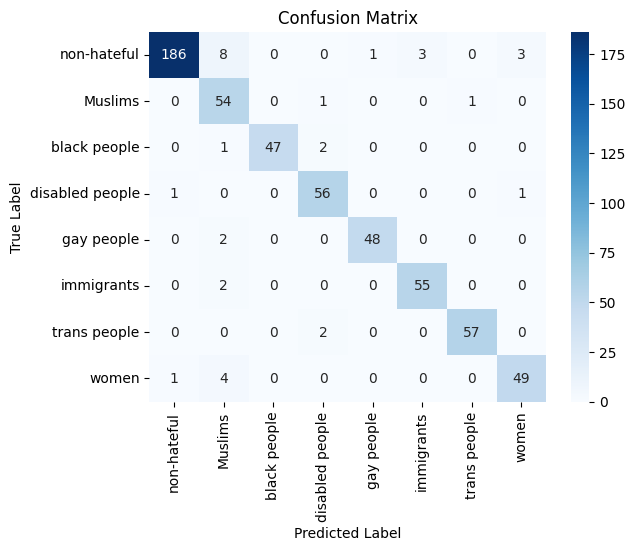

In [52]:
cm(model_final, test_single, group_map)

In [56]:
# evaluate final model
loss, acc = model_final.evaluate(test_single)
print(f"Single model: {round(acc, 3)} accuracy")

5/5 [==============================] - 0s 23ms/step - loss: 0.2083 - accuracy: 0.9436
Single model: 0.944 accuracy


## Manual Testing

Model has learned to correctly identify:  
- hating a person is not hate speech  
- adding negating words changes the meaning (I hate vs I don't hate)  
- trying to get around detection using 1337 speak and censoring with '*'

In [99]:
manual_test_phrases = [
    "I fucking hate you.",
    "I hate women",
    "I don't hate women",
    "I hate g4y people",
    "I hate bl*ck people",
    "I hate you people"
]

# make predictions and print results, getting class names from group_map
model_predictions = np.argmax(model_final.predict(manual_test_phrases), axis=1)
for prediction, phrase in zip(model_predictions, manual_test_phrases):
    print(f"Input: \"{phrase}\"\nResult: {group_map[prediction]}\n")

1/1 [==============================] - 0s 51ms/step
Input: "I fucking hate you."
Result: non-hateful

Input: "I hate women"
Result: women

Input: "I don't hate women"
Result: non-hateful

Input: "I hate g4y people"
Result: gay people

Input: "I hate bl*ck people"
Result: black people

Input: "I hate you people"
Result: non-hateful



# Conclusion

The single model approach solved the problem best, with a final model accuracy around 94.5%  

Given the imbalanced dataset where 66% of data belongs to hateful classes and 34% to non-hateful, as well as the small amount of data in general (4000 datapoints), I think this result is reasonably good for a small model made from scratch that can easily run on a weak computer  

The types of faults the model makes tends to be classifying non-hateful text as hateful (false positives)  
In order to further improve model performance and balance out the type of faults the model makes, non-hateful data would need to be increased in comparison to hateful data. Especially given a real-world scenario where non-hateful text is far more common than hateful one.  

Improvements to model's tendency of making false positives:  
- Gathering online datasets with non-hateful text  
- Scraping non-hateful text from websites  
- Oversampling existing non-hateful text in the dataset (if, like in this project, the goal is to only work with the given data)  
- Custom loss function aimed at punishing false positives more than false negatives  

Improvements to the performance of the model in general could be made by:  
- Further exploring hyperparameters - trying new settings, exploring combinations more extensively  
- Augmenting data in other ways - such as changing words for synonyms, translating to another language and back, changing word order  
- Experimenting with removal of stopwords  
- Experimenting with entirely different model architectures, such as much larger models or much deeper with many narrow layers  
- Cleaning data - manually going through the dataset to remove bad datapoints, such as unclearly labeled ones  

